In [1]:
from PIL import Image
from diffusers.utils import make_image_grid
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import numpy as np
from einops import rearrange
from src.preprocess.humanparsing.run_parsing import Parsing
from src.preprocess.openpose.run_openpose import OpenPose
from src.utils.mask import get_mask_location

In [2]:
gpu_id = 0
human_parser = Parsing(gpu_id)
openpose = OpenPose(gpu_id)

/home/jupyter/H-engine/src/preprocess/openpose/annotator/openpose/body.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load

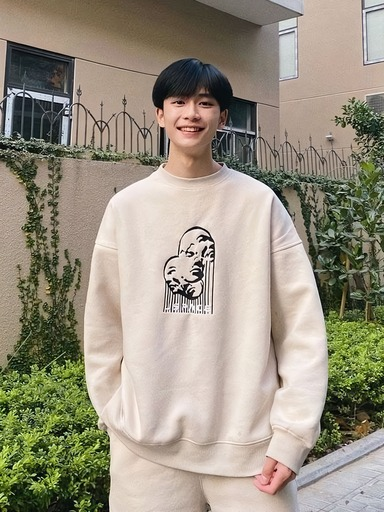

In [9]:
h, w = (512, 384)
# h, w = (1024, 768)
img = Image.open('../assets/man3_good.jpg').resize((w, h))
img

In [10]:
# keypoints = openpose(img)
body_parse, _  = human_parser(img)
# mask, mask_gray = get_mask_location(
#     model_type='hd',
#     category='upper_body',
#     model_parse=body_parse,
#     keypoint=keypoints,
#     width=w,
#     height=h
# )

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


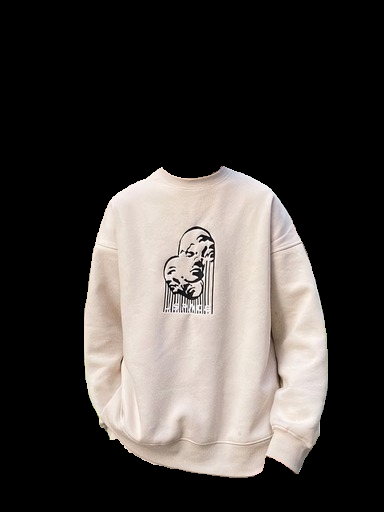

In [11]:
outfit_mask_arr = np.array(body_parse) == 4
original_img_arr = np.array(img)

outfit_mask_arr = np.stack([outfit_mask_arr] * 3)
outfit_mask_arr = rearrange(outfit_mask_arr, 'c h w -> h w c')
outfit_pix_arr = np.where(outfit_mask_arr, original_img_arr, original_img_arr * 0)

parsed_cloth = Image.fromarray(outfit_pix_arr)
parsed_cloth.save('/tmp/parsed_cloth.jpg')
parsed_cloth

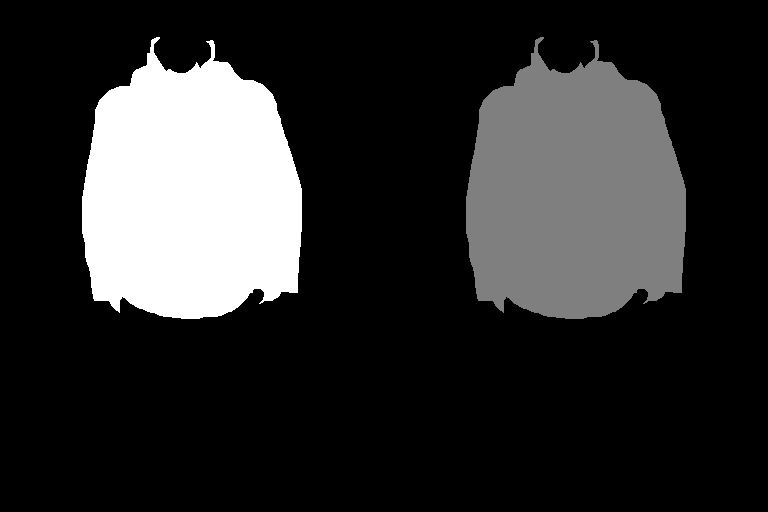

In [13]:
make_image_grid([mask, mask_gray], rows=1, cols=2)

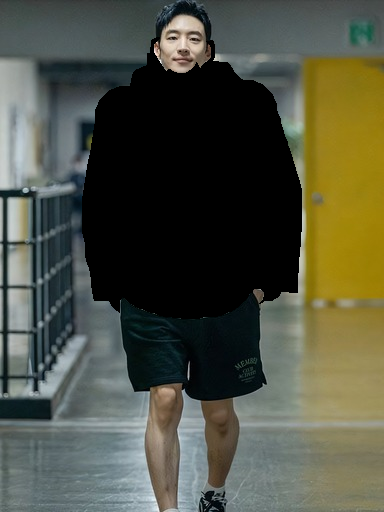

In [14]:
img_tensor = pil_to_tensor(img)
mask_tensor = pil_to_tensor(mask)
agnostic_img_tensor = img_tensor * (mask_tensor < 255)
to_pil_image(agnostic_img_tensor)